In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/Notebooks"

/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/Notebooks


In [ ]:
#from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from numpy import isnan

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]


In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def numerization(df, features = 0):

  for features in df.iloc[:,1:6]:
    df.iloc[0:][features] = df.iloc[0:][features].astype(str).str.replace(',', '', regex=True)
    df.iloc[0:][features] = df.iloc[0:][features].astype(str).str.replace('K', '000', regex=True)
    df.iloc[0:][features] = df.iloc[0:][features].astype(str).str.replace('%', '', regex=True)
    #df.loc[:,'volume']= (df.loc[:,'volume']).replace('K,', '000', rege/x=True)
    df.iloc[0:][features] = (df.iloc[0:][features]).apply(lambda x: float(x))
  return df
  #print(df.head(2))


def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

def rmse(pred, label):
    return np.sqrt(np.mean((pred - label) ** 2))


def createXY(dataset,n_past = 20):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col].str.replace(",","").str.replace("%",""))
    return df

def calculate_vwap_return_ratio(df):
    # Create a new column for VWAP
    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()
    # Create a new column for return ratio
    df['return_ratio_0'] = (df['vwap'].shift(-1) - df['vwap']) / df['vwap']
    return df

## Risk Analysis Indicators

In [ ]:
import numpy as np


def rank_IC(predicted_returns, actual_returns):
    """
    Calculate the rank IC of a set of predicted returns and actual returns.
    :param predicted_returns: array-like of shape (n_samples,)
    :param actual_returns: array-like of shape (n_samples,)
    :return: float
    """
    # Create a DataFrame with the predicted and actual returns
    data = {'predicted_returns': predicted_returns, 'actual_returns': actual_returns}
    df = pd.DataFrame(data)

    # Calculate the spearman correlation between the predicted and actual returns
    ic = df.corr(method='spearman')['predicted_returns']['actual_returns']
    # Calculate the mean and standard deviation of the IC
    mean_ic = ic.mean()
    std_ic = ic.std()
    # Return the rank IC
    if std_ic == 0 or abs(mean_ic) == 1:
      return mean_ic
    else:
      return mean_ic / std_ic



def rank_IR(returns):
    """
    Calculate the rank IR of a given set of returns.
    :param returns: array-like of shape (n_samples,)
    :return: float
    """
    # Calculate the mean and standard deviation of the returns
    mean = np.mean(returns)
    std = np.std(returns)
    return mean / std

import numpy as np

def annual_return(returns, periods_per_year=252):
    """
    Calculate the annualized return of a set of returns.
    :param returns: array-like of shape (n_samples,)
    :param periods_per_year: int, number of periods per year, defaults to 252 (trading days)
    :return: float
    """
    # Calculate the cumulative return
    cum_return = (1 + returns).prod()
    # Annualize the return
    n = len(returns)
    ar = (cum_return ** (periods_per_year / n)) - 1
    # Return the annualized return
    return ar * 100

def sharpe_ratio(returns, risk_free_rate=0, periods_per_year=252):
    """
    Calculate the Sharpe ratio of a given set of returns.
    :param returns: array-like of shape (n_samples,)
    :param risk_free_rate: float
    :param periods_per_year: int
    :return: float
    """
    # Calculate the excess returns
    excess_returns = returns - risk_free_rate
    # Calculate the annualized excess returns
    annualized_excess_returns = excess_returns.mean() * periods_per_year
    # Calculate the annualized volatility
    annualized_volatility = excess_returns.std() * np.sqrt(periods_per_year)
    # Calculate the Sharpe ratio
    return annualized_excess_returns / annualized_volatility

def max_drawdown(returns):
    """
    Calculate the maximum drawdown of a given set of returns.
    :param returns: array-like of shape (n_samples,)
    :return: float
    """
    # Calculate the cumulative returns
    cumulative_returns = (1 + returns).cumprod()
    # Calculate the maximum drawdown
    return (cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()

def max_drawdown0(returns):
    cumulative_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdown)
    return max_drawdown




In [ ]:
import tensorflow as tf

class CorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name='correlation_coefficient', **kwargs):
        super(CorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.correlation = self.add_weight(name='correlation', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        y_true_mean = tf.math.reduce_mean(y_true)
        y_pred_mean = tf.math.reduce_mean(y_pred)
        numerator = tf.math.reduce_sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
        denominator = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(y_true - y_true_mean)) * tf.math.reduce_sum(tf.math.square(y_pred - y_pred_mean)))
        correlation = numerator / denominator
        self.correlation.assign(correlation)

    def result(self):
        return self.correlation
    
    def reset_states(self):
        self.correlation.assign(0)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/csi_300_final_version.csv")
df.head(5)

,datetime,close,open,high,low,volume,pct_change,adj.close
0,2007-01-02,2395.17,2350.60,2410.42,2310.57,65.08,0.41,2404.990119
1,2007-01-03,2473.54,2550.26,2550.33,2439.50,82.16,-2.79,2404.528272
2,2007-01-06,3803.95,3953.10,4014.15,3780.03,119.94,-3.16,3683.745133
3,2007-01-08,4290.48,4479.30,4496.25,4271.06,79.36,-3.81,4127.012693
4,2007-01-11,5605.23,5701.49,5702.21,5604.79,46.61,-1.46,5523.393623


In [ ]:
#df['adj.close'] = df['close'] * (1 + df['pct_change']/100)

In [ ]:
df['return_ratio'] = df['adj.close'].pct_change()
df['return_ratio'] = df['return_ratio'].fillna(0)

In [ ]:
df['cum_return'] = np.cumsum(df['return_ratio'])

In [ ]:
calculate_vwap_return_ratio(df)

,datetime,close,open,high,low,volume,pct_change,adj.close,return_ratio,cum_return,vwap,return_ratio_0
0,2007-01-02,2395.17,2350.60,2410.42,2310.57,65.08,0.41,2404.990119,0.000000,0.000000,2395.170000,0.018258
1,2007-01-03,2473.54,2550.26,2550.33,2439.50,82.16,-2.79,2404.528272,-0.000192,-0.000192,2438.900503,0.251255
2,2007-01-06,3803.95,3953.10,4014.15,3780.03,119.94,-3.16,3683.745133,0.532003,0.531811,3051.686028,0.092962
3,2007-01-08,4290.48,4479.30,4496.25,4271.06,79.36,-3.81,4127.012693,0.120331,0.652142,3335.378213,0.080681
4,2007-01-11,5605.23,5701.49,5702.21,5604.79,46.61,-1.46,5523.393623,0.338351,0.990493,3604.481079,-0.052799
...,...,...,...,...,...,...,...,...,...,...,...,...
3160,2019-12-25,3990.87,3988.66,4000.56,3976.36,94.94,-0.05,3988.874682,-0.007475,21.370116,3425.980411,0.000061
3161,2019-12-26,4025.99,3993.67,4025.99,3993.54,108.86,0.88,4061.418702,0.018187,21.388303,3426.189705,0.000084
3162,2019-12-27,4022.03,4029.25,4066.80,4019.72,150.93,-0.10,4018.007999,-0.010689,21.377615,3426.477726,0.000095
3163,2019-12-30,4081.63,4015.52,4083.69,4001.50,155.97,1.48,4142.038005,0.030869,21.408483,3426.804830,0.000077


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot as plt

# Create train data set
train_split_date = '2014-12-31'
x_train_close = df.loc[df['datetime'] <= train_split_date]['adj.close']

# Create test data set
test_split_date = '2016-12-30'
x_test_close = df.loc[df['datetime'] >= test_split_date]['adj.close']

# Create valid data set
x_valid_close = df.loc[(df['datetime'] < test_split_date) & (df['datetime'] > train_split_date)]['adj.close']


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/x_test_close.pickle', 'wb') as handle:
    pickle.dump(x_test_close, handle)

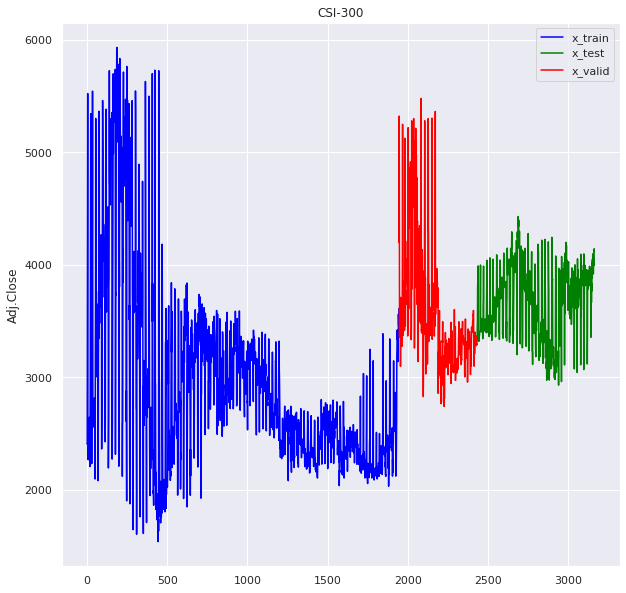

In [ ]:
plt.plot(x_train_close, label='x_train', color='blue')
plt.plot(x_test_close, label='x_test', color='green')
plt.plot(x_valid_close, label='x_valid', color='red')
plt.ylabel("Adj.Close")
plt.title("CSI-300")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot as plt

# Create train data set
train_split_date = '2014-12-31'
x_train_return = df.loc[df['datetime'] <= train_split_date]['return_ratio_0']

# Create test data set
test_split_date = '2016-12-30'
x_test_return = df.loc[df['datetime'] >= test_split_date]['return_ratio_0']

# Create valid data set
x_valid_return = df.loc[(df['datetime'] < test_split_date) & (df['datetime'] > train_split_date)]['return_ratio_0']

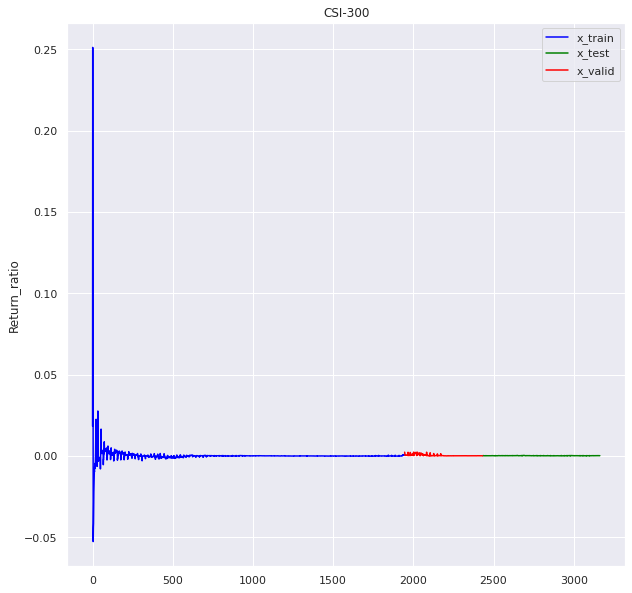

In [ ]:
plt.plot(x_train_return, label='x_train', color='blue')
plt.plot(x_test_return, label='x_test', color='green')
plt.plot(x_valid_return, label='x_valid', color='red')
plt.title("CSI-300")
plt.ylabel("Return_ratio")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot as plt

# Create train data set
train_split_date = '2014-12-31'
x_train_cum = df.loc[df['datetime'] <= train_split_date]['cum_return']

# Create test data set
test_split_date = '2016-12-30'
x_test_cum = df.loc[df['datetime'] >= test_split_date]['cum_return']

# Create valid data set
x_valid_cum = df.loc[(df['datetime'] < test_split_date) & (df['datetime'] > train_split_date)]['cum_return']

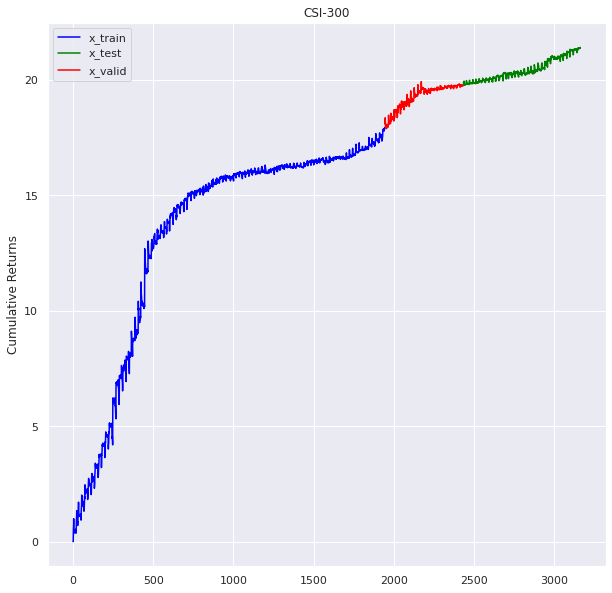

In [ ]:
plt.plot(x_train_cum, label='x_train', color='blue')
plt.plot(x_test_cum, label='x_test', color='green')
plt.plot(x_valid_cum, label='x_valid', color='red')
plt.title("CSI-300")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(['datetime'], inplace = True)

In [ ]:
df.head(2)

,close,open,high,low,volume,pct_change,adj.close,return_ratio,vwap,return_ratio_0
datetime,,,,,,,,,,
2007-01-02,2395.17,2350.60,2410.42,2310.57,65.08,0.41,2404.990119,0.000000,2395.170000,0.018258
2007-01-03,2473.54,2550.26,2550.33,2439.50,82.16,-2.79,2404.528272,-0.000192,2438.900503,0.251255


* Monthly Frequency

In [ ]:
x_train = df.loc[df.index <= train_split_date]['adj.close']
x_train_monthly = x_train.resample('M').mean()

x_test = df.loc[df.index >= test_split_date]['adj.close']
x_test_monthly = x_test.resample('M').mean()

x_valid = df.loc[(df.index > train_split_date) & (df.index < test_split_date)]['adj.close']
x_valid_monthly = x_valid.resample('M').mean()

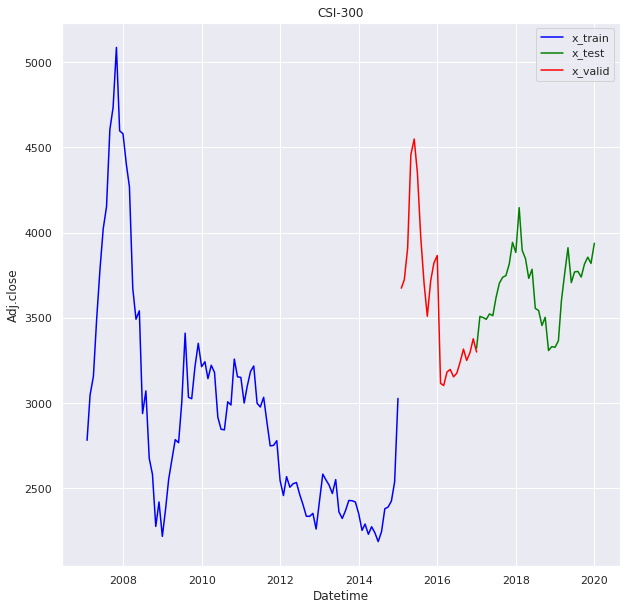

In [ ]:
plt.plot(x_train_monthly, label='x_train', color='blue')
plt.plot(x_test_monthly, label='x_test', color='green')
plt.plot(x_valid_monthly, label='x_valid', color='red')
plt.title("CSI-300")
plt.xlabel("Datetime")
plt.ylabel("Adj.close")
plt.legend()
plt.show()


In [ ]:
x_train_ret = df.loc[df.index <= train_split_date]['return_ratio_0']
x_train_monthly_ret = x_train_ret.resample('M').mean()

x_test_ret = df.loc[df.index >= test_split_date]['return_ratio_0']
x_test_monthly_ret = x_test_ret.resample('M').mean()

x_valid_ret = df.loc[(df.index > train_split_date) & (df.index < test_split_date)]['return_ratio_0']
x_valid_monthly_ret = x_valid_ret.resample('M').mean()

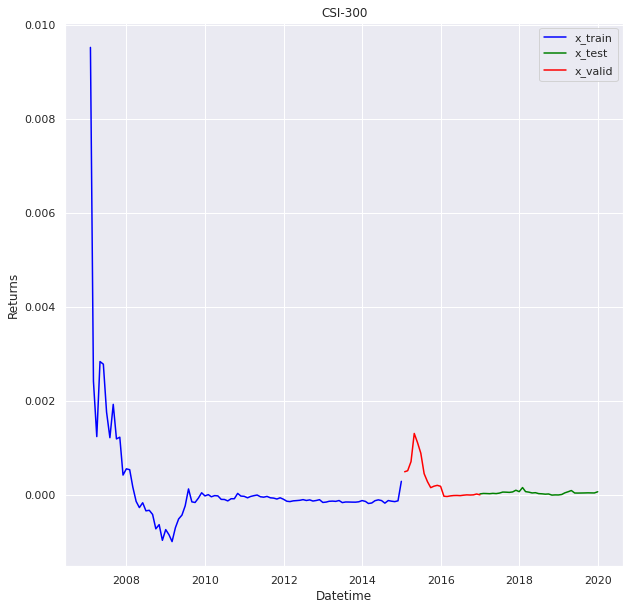

In [ ]:
plt.plot(x_train_monthly_ret, label='x_train', color='blue')
plt.plot(x_test_monthly_ret, label='x_test', color='green')
plt.plot(x_valid_monthly_ret, label='x_valid', color='red')
plt.title("CSI-300")
plt.xlabel("Datetime")
plt.ylabel("Returns")
plt.legend()
plt.show()

In [ ]:
df['cum_return'] = df.return_ratio_0.pct_change()

In [ ]:
x_train_cret = df.loc[df.index <= train_split_date]['cum_return']
x_train_monthly_cret = x_train_cret.resample('M').mean()

x_test_cret = df.loc[df.index >= test_split_date]['cum_return']
x_test_monthly_cret = x_test_cret.resample('M').mean()

x_valid_cret = df.loc[(df.index > train_split_date) & (df.index < test_split_date)]['cum_return']
x_valid_monthly_cret = x_valid_cret.resample('M').mean()

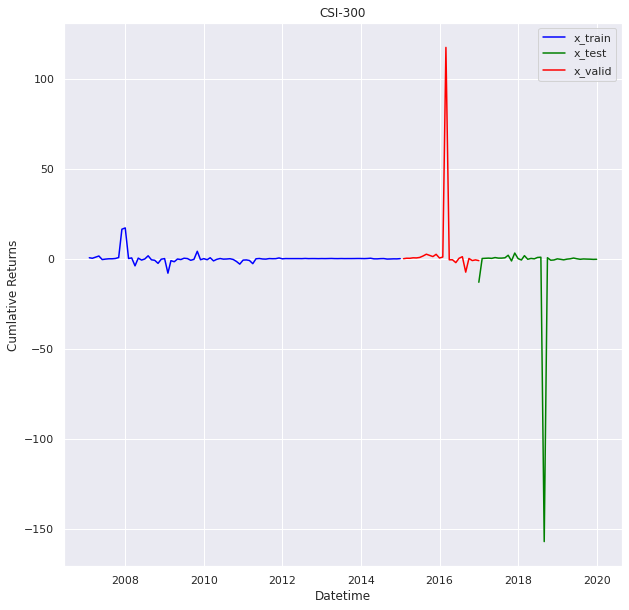

In [ ]:
plt.plot(x_train_monthly_cret, label='x_train', color='blue')
plt.plot(x_test_monthly_cret, label='x_test', color='green')
plt.plot(x_valid_monthly_cret, label='x_valid', color='red')
plt.title("CSI-300")
plt.xlabel("Datetime")
plt.ylabel("Cumlative Returns")
plt.legend()
plt.show()

In [ ]:
x_test_monthly_ret.index

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31'],
              dtype='datetime64[ns]', name='datetime', freq='M')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot as plt

In [ ]:
x_train.index

DatetimeIndex(['2007-01-02', '2007-01-03', '2007-01-06', '2007-01-08',
               '2007-01-11', '2007-01-15', '2007-01-16', '2007-01-17',
               '2007-01-18', '2007-01-19',
               ...
               '2014-12-18', '2014-12-19', '2014-12-22', '2014-12-23',
               '2014-12-24', '2014-12-25', '2014-12-26', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='datetime', length=1946, freq=None)

In [ ]:
x_train_close.shape

(1946,)

In [ ]:
x_test_close.shape

(732,)

In [ ]:
x_valid_close.shape

(487,)

#Data normalization with Z-Score.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_close.values.reshape(-1, 1))
x_valid_scaled = scaler.transform(x_valid_close.values.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test_close.values.reshape(-1, 1))

#Sliding Window Creation

In [ ]:
n_past = 20
x_train_scaled_windowed, y_train_scaled_windowed = createXY(x_train_scaled,n_past)
x_valid_scaled_windowed, y_valid_scaled_windowed = createXY(x_valid_scaled,n_past)
x_test_scaled_windowed, y_test_windowed_scaled = createXY(x_test_scaled,n_past)

In [ ]:
x_train_scaled_windowed.shape

(1926, 20, 1)

In [ ]:
y_train_scaled_windowed.shape

(1926,)

In [ ]:
x_valid_scaled_windowed.shape

(467, 20, 1)

In [ ]:
# Creation of a dictionary to store the models and their performance metrics
models = {'ALSTM': None, 'ADV-LSTM': None, 'Coarse-Grained RNN': None, 
          'Fine-Grained RNN': None, 'Linear Regression': None, 'Transformer': None}
metrics = {'MAE': [], 'RMSE': []}


In [ ]:
## ALSTM
# Import required libraries
from keras.layers import Input, LSTM, Dense, Attention, concatenate,Dropout
from keras.models import Model

# Define the input shape for the LSTM
input_shape = (20, 1)

# Create the input layer for the model with the defined input shape
inputs = Input(shape=input_shape)

# Create the LSTM layer with 300 units and return sequences
lstm_out = LSTM(300, return_sequences=True)(inputs)

# Add a dropout layer with dropout rate of 0.2
dropout_1 = Dropout(0.2)(lstm_out)

# Create another LSTM layer with 200 units and return sequences
lstm_out_2 = LSTM(200, return_sequences=True)(dropout_1)

# Add a dropout layer with dropout rate of 0.2
dropout_2 = Dropout(0.2)(lstm_out_2)

# Create the Attention layer with default parameters
attention = Attention()([dropout_2, dropout_2])

# Add a dense layer with 1 unit
outputs = Dense(1)(attention)

# Create the model with the input and output layers
alstm = Model(inputs=inputs, outputs=outputs)

# compile the model
alstm.compile(optimizer='adam', loss='mean_squared_error')

alstm.fit(x_train_scaled_windowed, y_train_scaled_windowed, epochs=50, batch_size=300, verbose=0, validation_data=(x_valid_scaled_windowed, y_valid_scaled_windowed))
predictions_alstm = alstm.predict(x_test_scaled)
predictions_alstm = scaler.inverse_transform(predictions_alstm.reshape(-1,1))

23/23 [==============================] - 1s 5ms/step


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_alstm.pickle', 'wb') as handle:
    pickle.dump(predictions_alstm, handle)


In [ ]:
from posixpath import split
from sklearn.model_selection import train_test_split
x_train_scaled_lr, y_train_scaled_lr = train_test_split(x_train_scaled, test_size = 0.5)

In [ ]:
# ADV-LSTM
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

# define the input shape
input_shape = (20, 1)

# define the generator model
generator = Sequential()
generator.add(LSTM(10, input_shape=input_shape))
generator.add(Dense(1))
generator.compile(optimizer='adam', loss='mean_squared_error')

# define the discriminator model
discriminator = Sequential()
discriminator.add(LSTM(10, input_shape=input_shape))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(optimizer='adam', loss='binary_crossentropy')


# fit the generator and discriminator models separately
generator.fit(x_train_scaled_windowed, y_train_scaled_windowed, epochs=50)
discriminator.fit(x_train_scaled_windowed, y_train_scaled_windowed, epochs=50)

# define the inputs for the adversarial model
inputs = Input(shape=input_shape)

# generate a time series
generated_time_series = generator(inputs)

# use the discriminator to classify the generated time series as real or fake
is_real = discriminator(generated_time_series)

# create the adversarial model
adversarial_model = Model(inputs=inputs, outputs=generated_time_series)
adversarial_model.compile(optimizer=Adam(0.0002, 0.5), loss='mean_squared_error')

# train the adversarial model
adversarial_model.fit(x=x_train_scaled_windowed, y=y_train_scaled_windowed, epochs=50)



Epoch 1/50
61/61 [==============================] - 3s 9ms/step - loss: 0.5010
Epoch 2/50
61/61 [==============================] - 1s 9ms/step - loss: 0.3867
Epoch 3/50
61/61 [==============================] - 1s 9ms/step - loss: 0.3596
Epoch 4/50
61/61 [==============================] - 1s 9ms/step - loss: 0.3378
Epoch 5/50
61/61 [==============================] - 1s 9ms/step - loss: 0.3204
Epoch 6/50
61/61 [==============================] - 1s 10ms/step - loss: 0.3028
Epoch 7/50
61/61 [==============================] - 1s 9ms/step - loss: 0.2856
Epoch 8/50
61/61 [==============================] - 1s 9ms/step - loss: 0.2708
Epoch 9/50
61/61 [==============================] - 1s 9ms/step - loss: 0.2586
Epoch 10/50
61/61 [==============================] - 1s 9ms/step - loss: 0.2476
Epoch 11/50
61/61 [==============================] - 1s 9ms/step - loss: 0.2405
Epoch 12/50
61/61 [==============================] - 1s 9ms/step - loss: 0.2323
Epoch 13/50
61/61 [=============================

Epoch 1/50
61/61 [==============================] - 3s 9ms/step - loss: 0.2001
Epoch 2/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1999
Epoch 3/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1994
Epoch 4/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1993
Epoch 5/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1995
Epoch 6/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1986
Epoch 7/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1994
Epoch 8/50
61/61 [==============================] - 1s 10ms/step - loss: 0.1992
Epoch 9/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1984
Epoch 10/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1985
Epoch 11/50
61/61 [==============================] - 1s 9ms/step - loss: 0.1981
Epoch 12/50
61/61 [==============================] - 1s 10ms/step - loss: 0.1979
Epoch 13/50
61/61 [============================

In [ ]:
predictions_adv = adversarial_model.predict(x_test_scaled_windowed)
predictions_adv = scaler.inverse_transform(predictions_adv.reshape(-1,1))
x_test_windowed = scaler.inverse_transform(x_test_scaled_windowed.reshape(-1,1))
mae = mean_absolute_error(x_test_windowed[:712], predictions_adv)
rmse = np.sqrt(mean_squared_error(x_test_windowed[:712], predictions_adv))

23/23 [==============================] - 0s 3ms/step


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_adv.pickle', 'wb') as handle:
    pickle.dump(predictions_adv, handle)


In [ ]:
# Linear Regression
# Save target series
#series = df['close']
# All values normalized to training data
#csi_300_normalized_to_traindata = scaler.fit_transform(series.values.reshape(-1, 1))
lr = LinearRegression()
lr.fit(x_train_scaled_lr, y_train_scaled_lr)
predictions_lr = lr.predict(x_test_scaled)
predictions_lr = scaler.inverse_transform(predictions_lr.reshape(-1,1))
predictions_lr = predictions_lr.reshape(732,1)
mae = mean_absolute_error(x_test, predictions_lr)
rmse = np.sqrt(mean_squared_error(x_test, predictions_lr))
models['Linear Regression'] = lr
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_lr.pickle', 'wb') as handle:
    pickle.dump(predictions_lr, handle)

In [ ]:
df.head(5)

,close,open,high,low,volume,pct_change,adj.close,return_ratio,cum_return
datetime,,,,,,,,,
2007-01-02,2395.17,2350.60,2410.42,2310.57,65.08,0.41,2404.990119,0.000000,0.000000
2007-01-03,2473.54,2550.26,2550.33,2439.50,82.16,-2.79,2404.528272,-0.000192,-0.000192
2007-01-06,3803.95,3953.10,4014.15,3780.03,119.94,-3.16,3683.745133,0.532003,0.531811
2007-01-08,4290.48,4479.30,4496.25,4271.06,79.36,-3.81,4127.012693,0.120331,0.652142
2007-01-11,5605.23,5701.49,5702.21,5604.79,46.61,-1.46,5523.393623,0.338351,0.990493


In [ ]:
x_train_monthly_scaled = scaler.fit_transform(x_train_monthly.values.reshape(-1, 1))
x_valid_monthly_scaled = scaler.fit_transform(x_valid_monthly.values.reshape(-1, 1)) 
x_test_monthly_scaled = scaler.fit_transform(x_test_monthly.values.reshape(-1, 1))

In [ ]:
x_train_monthly_scaled, y_train_monthly_scaled = train_test_split(x_train_monthly_scaled, test_size = 0.5)

In [ ]:
# Coarse Grained RNN - Month

from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import Activation, Dense, Reshape
from keras.preprocessing.sequence import TimeseriesGenerator

rnn_type = 'LSTM'
rnn_layer = 2
hid_size = 64
dropout = 0
optim_method = 'Adam'
optim_args = {'lr': 1e-3}
loss_fn = 'mse'
batch_size = 300
#feature_num = 1
#seq_length = 20

# Architecture
cgrnn = Sequential()
cgrnn.add(LSTM(96, activation='tanh', input_shape=(20, 1), return_sequences = True))
#model.add(Input(input_shape))
cgrnn.add(Dense(hid_size))
cgrnn.add(Dense(hid_size))
cgrnn.add(Activation('tanh'))
cgrnn.add(Dropout(dropout))
cgrnn.add(LSTM(hid_size, return_sequences=True, dropout=dropout))
for _ in range(rnn_layer-2):
    cgrnn.add(LSTM(hid_size, return_sequences=True, dropout=dropout))
cgrnn.add(LSTM(hid_size, dropout=dropout))
cgrnn.add(Dense(1))

cgrnn.summary()
# Optimization
cgrnn.compile(optimizer=optim_method, loss=loss_fn, metrics= [CorrelationCoefficient()])
#define generator
generator = TimeseriesGenerator(x_train_monthly_scaled, y_train_monthly_scaled, length=20, batch_size=300)
# fit model on generator
history = cgrnn.fit(generator, epochs=100)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 96)            37632     
                                                                 
 dense_3 (Dense)             (None, 20, 64)            6208      
                                                                 
 dense_4 (Dense)             (None, 20, 64)            4160      
                                                                 
 activation (Activation)     (None, 20, 64)            0         
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)               

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2086: UserWarning: Metric CorrelationCoefficient implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1/1 [==============================] - 0s 23ms/step - loss: 1.0201 - correlation_coefficient: 0.2585
Epoch 9/100
1/1 [==============================] - 0s 22ms/step - loss: 1.0099 - correlation_coefficient: 0.2622
Epoch 10/100
1/1 [==============================] - 0s 22ms/step - loss: 1.0044 - correlation_coefficient: 0.2663
Epoch 11/100
1/1 [==============================] - 0s 20ms/step - loss: 1.0043 - correlation_coefficient: 0.2714
Epoch 12/100
1/1 [==============================] - 0s 19ms/step - loss: 1.0044 - correlation_coefficient: 0.2780
Epoch 13/100
1/1 [==============================] - 0s 20ms/step - loss: 1.0011 - correlation_coefficient: 0.2852
Epoch 14/100
1/1 [==============================] - 0s 21ms/step - loss: 0.9941 - correlation_coefficient: 0.2924
Epoch 15/100
1/1 [==============================] - 0s 24ms/step - loss: 0.9860 - correlation_coefficient: 0.2992
Epoch 16/100
1/1 [==============================] - 0s 19ms/step - loss: 0.9814 - correlation_coeffici

In [ ]:
predictions_cgrnn = cgrnn.predict(x_test_scaled.reshape(-1, 1))
predictions_cgrnn = scaler.inverse_transform(predictions_cgrnn.reshape(-1,1))
mae = mean_absolute_error(x_test, predictions_cgrnn)
rmse = np.sqrt(mean_squared_error(x_test, predictions_cgrnn))
models['Coarse-Grained RNN'] = cgrnn
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)

23/23 [==============================] - 1s 5ms/step


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_cgrnn.pickle', 'wb') as handle:
    pickle.dump(predictions_cgrnn, handle)

In [ ]:
# Fine-Grained RNN - Day
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import Activation, Dense, Reshape
from keras.preprocessing.sequence import TimeseriesGenerator

rnn_type = 'LSTM'
rnn_layer = 2
hid_size = 64
dropout = 0
optim_method = 'Adam'
optim_args = {'lr': 1e-3}
loss_fn = 'mse'
batch_size = 300
#feature_num = 1
#seq_length = 20

# Architecture
fgrnn = Sequential()
fgrnn.add(LSTM(96, activation='tanh', input_shape=(20, 1), return_sequences = True))
#model.add(Input(input_shape))
fgrnn.add(Dense(hid_size))
fgrnn.add(Dense(hid_size))
fgrnn.add(Activation('tanh'))
fgrnn.add(Dropout(dropout))
fgrnn.add(LSTM(hid_size, return_sequences=True, dropout=dropout))
for _ in range(rnn_layer-2):
    fgrnn.add(LSTM(hid_size, return_sequences=True, dropout=dropout))
fgrnn.add(LSTM(hid_size, dropout=dropout))
fgrnn.add(Dense(1))

fgrnn.summary()
# Optimization
fgrnn.compile(optimizer=optim_method, loss=loss_fn, metrics= [CorrelationCoefficient()])
#define generator
generator = TimeseriesGenerator(x_train_scaled_lr, y_train_scaled_lr, length=20, batch_size=300)
# fit model on generator
history = fgrnn.fit(generator, epochs=100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 96)            37632     
                                                                 
 dense_6 (Dense)             (None, 20, 64)            6208      
                                                                 
 dense_7 (Dense)             (None, 20, 64)            4160      
                                                                 
 activation_1 (Activation)   (None, 20, 64)            0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_8 (LSTM)               (None, 64)               

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2086: UserWarning: Metric CorrelationCoefficient implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


4/4 [==============================] - 0s 13ms/step - loss: 1.0120 - correlation_coefficient: 0.1196
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0120 - correlation_coefficient: 0.0424
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0123 - correlation_coefficient: 0.1447
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 1.0117 - correlation_coefficient: 0.1459
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0118 - correlation_coefficient: 0.0417
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0120 - correlation_coefficient: 0.1623
Epoch 11/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0105 - correlation_coefficient: 0.1694
Epoch 12/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0107 - correlation_coefficient: 0.1778
Epoch 13/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0133 - correlation_coefficient

In [ ]:
predictions_fgrnn = fgrnn.predict(x_test_scaled.reshape(-1, 1))
predictions_fgrnn = scaler.inverse_transform(predictions_fgrnn.reshape(-1,1))
mae = mean_absolute_error(x_test, predictions_fgrnn)
rmse = np.sqrt(mean_squared_error(x_test, predictions_fgrnn))
models['Fine-Grained RNN'] = fgrnn
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)

23/23 [==============================] - 1s 3ms/step


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_fgrnn.pickle', 'wb') as handle:
    pickle.dump(predictions_fgrnn, handle)

In [ ]:
# Transformer
from tensorflow.keras.layers import Input, Attention, Dense
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(n_past, 1))

# Define the first encoder layer
encoder_layer_1 = Attention()([input_layer,input_layer,input_layer])

# Define the second encoder layer
encoder_layer_2 = Attention()([encoder_layer_1,encoder_layer_1,encoder_layer_1])

# Define the output layer
output_layer = Dense(1)(encoder_layer_2)

# Create the model
transformer = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
transformer.compile(optimizer='adam', loss='mean_squared_error')

history_transf = transformer.fit(x_train_scaled_windowed, y_train_scaled_windowed, epochs=50, batch_size=300, verbose=0)

predictions_transf = transformer.predict(x_test_scaled.reshape(-1, 1))
predictions_transf = scaler.inverse_transform(predictions_transf.reshape(-1,1))
# calculate the evaluation metrics
mae = mean_absolute_error(x_test, predictions_transf)
rmse = np.sqrt(mean_squared_error(x_test, predictions_transf))
models['Transformer'] = transformer
metrics['MAE'].append(mae)
metrics['RMSE'].append(rmse)

23/23 [==============================] - 0s 2ms/step


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_transf.pickle', 'wb') as handle:
    pickle.dump(predictions_transf, handle)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/metrics.pickle', 'wb') as handle:
    pickle.dump(metrics, handle)

In [ ]:
models.keys()

dict_keys(['ALSTM', 'ADV-LSTM', 'Coarse-Grained RNN', 'Fine-Grained RNN', 'Linear Regression', 'Transformer', 'Multi-Grained RNN', 'Fine-Grained-RNN'])

## Loading Models

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_transf.pickle', 'rb') as handle:
    predictions_transf = pickle.load(handle)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_lr.pickle', 'rb') as handle:
    predictions_lr = pickle.load(handle)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_fgrnn.pickle', 'rb') as handle:
    predictions_fgrnn = pickle.load(handle)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_cgrnn.pickle', 'rb') as handle:
    predictions_cgrnn = pickle.load(handle)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_adv.pickle', 'rb') as handle:
    predictions_adv = pickle.load(handle)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Special_Subject_Rafailidis/Special sub/pickle_files/predictions_alstm.pickle', 'rb') as handle:
    predictions_alstm = pickle.load(handle)

# Comparison Table Evaluation Metrics (RMSE/MAE)

In [ ]:

predictions_alstm = predictions_alstm[:712]
predictions_fgrnn = predictions_fgrnn[:712]
predictions_cgrnn = predictions_cgrnn[:712]
predictions_lr = predictions_lr[:712]
predictions_transf = predictions_transf[:712]
print(predictions_alstm.shape)
print(predictions_adv.shape)
print(predictions_fgrnn.shape)
print(predictions_cgrnn.shape)
print(predictions_lr.shape)
print(predictions_transf.shape)

(712, 1)
(712, 1)
(712, 1)
(712, 1)
(712, 1)
(712, 1)


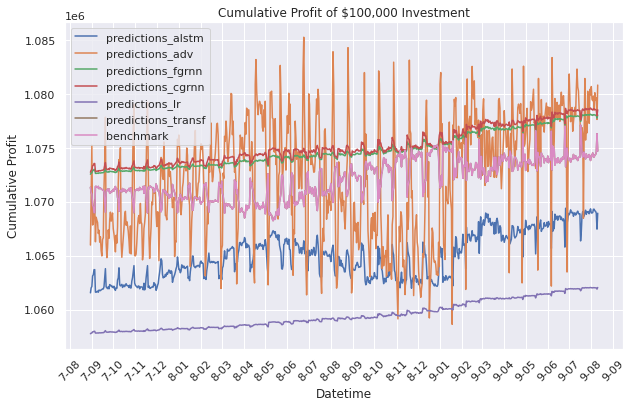

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates

K = 20
init_inv = 1000000
cumulative_profit = {}
cumulative_returns = {}
model_list = ['predictions_alstm','predictions_adv', 'predictions_fgrnn', 'predictions_cgrnn', 'predictions_lr', 'predictions_transf']
#risk_indicators = {'Model': [], 'RankIC': [], 'RankIR': [], 'AR': [], 'Sharpe': [], 'MDD': []}
# Create empty lists to store evaluation metrics
rmse_list = []
mae_list = []

for model in model_list:
    predictions = eval(model)
    #print(predictions.shape)
    #x_test_return = x_test_return.values
    predicted_returns = (predictions - np.array(x_test_return.reshape(-1,1)[:712]) / np.array(x_test_return).reshape(-1,1)[:712] ) - 1

    cum_predicted_returns = np.cumsum(predicted_returns)

    profit = predicted_returns * np.array(x_test_cum).reshape(-1,1)[:712] + init_inv

    # Calculate the cumulative profit by summing the profits
    cum_profit = np.cumsum(profit)
    # Add the cumulative profit to the dictionary
    cumulative_profit[model] = profit
    # Add the cumulative profit to the dictionary
    cumulative_returns[model] = cum_predicted_returns
    
    # Mean and standard deviation of the target variable
    mean_x_test_return = np.mean(x_test_return[:712])
    std_x_test_return = np.std(x_test_return[:712])

    # Normalize the target variable and predicted values
    normalized_x_test_return = (x_test_return[:712] - mean_x_test_return) / std_x_test_return
    normalized_predicted_returns = (predicted_returns - mean_x_test_return) / std_x_test_return

    # Calculate the Z-score normalized MAE and RMSE
    mae = mean_absolute_error(normalized_x_test_return, normalized_predicted_returns)
    rmse = np.sqrt(mean_squared_error(normalized_x_test_return, normalized_predicted_returns))

    # Append evaluation metrics to lists
    rmse_list.append(rmse)
    mae_list.append(mae)
    




plt.figure(figsize=(10, 6))

for model in cumulative_profit.keys():
  plt.plot(x_test_close.index[:712], cumulative_profit[model] , label=model)



# Plot the benchmark
plt.plot(x_test_close.index[:712],profit, label = "benchmark")



# Format the x-axis labels to show only the year and month
plt.gca().xaxis_date()
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Datetime')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit of $100,000 Investment')
plt.legend(loc='best')
plt.show()



In [ ]:
def calc_MDD(return_series):
    cum_return = (return_series + 1).cumprod()
    peak_idx = np.where(cum_return == np.maximum.accumulate(cum_return))[0]
    drawdown = np.zeros(len(cum_return))
    for i in peak_idx:
        drawdown[i:] = np.minimum(drawdown[i:], cum_return[i] - cum_return[i:])
    return np.min(drawdown)




## Calculation of the risk indicators for each model

In [ ]:
risk_indicators = {'Model': [], 'RankIC': [], 'RankIR': [], 'AR (%)': [], 'Sharpe': [], 'MDD': []}

mae_list = []
rmse_list = []
# Calculation of the risk indicators for each model
for model in model_list:



  predictions = eval(model)
  predictions = pd.DataFrame(predictions)
  #predicted_returns = (predictions - np.array(x_test_close).reshape(-1,1)[:712]) / np.array(x_test_return).reshape(-1,1)[:712]  - 1
  predicted_returns = predictions.shift(-1) / predictions - 1
  predicted_returns = np.nan_to_num(predicted_returns)
  rmse = np.sqrt(mean_squared_error(x_test_return[:712] , predicted_returns))
  mae = mean_absolute_error(x_test_return[:712], predicted_returns)
    #predicted_returns = predicted_returns
    #predicted_returns = (predictions / predictions.shift(1)) - 1
  if np.count_nonzero(predicted_returns) != 0:

      rankIC = rank_IC(np.array(predicted_returns).ravel(), x_test_return[:712])
      rankIR = rank_IR(predicted_returns)
      ar = annual_return(predicted_returns, periods_per_year= 24)
      sharpe = sharpe_ratio(predicted_returns)
      mdd = calc_MDD(np.array(predicted_returns).ravel())
      
      # Add the risk indicators to the dictionary
      risk_indicators['Model'].append(model)
      risk_indicators['RankIC'].append(rankIC)
      risk_indicators['RankIR'].append(rankIR)
      risk_indicators['AR (%)'].append(ar)
      risk_indicators['Sharpe'].append(sharpe)
      risk_indicators['MDD'].append(mdd)
      rmse_list.append(mae)
      mae_list.append(rmse)

# Convertion from dictionary to a DataFrame
risk_indicators_df = pd.DataFrame(risk_indicators)

# Print the comparison table
risk_indicators_df

,Model,RankIC,RankIR,AR (%),Sharpe,MDD
0,predictions_alstm,0.296386,0.002890,0.000575,0.045874,-0.000367
1,predictions_adv,0.214263,0.030295,0.429667,0.480912,-0.183498
2,predictions_fgrnn,-0.292534,-0.003004,-0.008161,-0.047687,-0.001090
3,predictions_cgrnn,0.293863,0.003249,0.003808,0.051576,-0.001968
4,predictions_lr,-0.297069,-0.001888,-0.013013,-0.029974,-0.004497
5,predictions_transf,-0.297933,0.004471,-0.098969,0.070973,-0.033783


In [ ]:
eval_metrics = pd.DataFrame({'Model': model_list, 'RMSE': rmse_list, 'MAE': mae_list})
eval_metrics.name = 'Evaluation Metrics - CSI_300'

In [ ]:
from IPython.display import display
display(eval_metrics)

,Model,RMSE,MAE
0,predictions_alstm,0.000067,0.000093
1,predictions_adv,0.035367,0.055630
2,predictions_fgrnn,0.000608,0.000992
3,predictions_cgrnn,0.000319,0.000519
4,predictions_lr,0.001184,0.001926
5,predictions_transf,0.008982,0.014567
